**<center><font size="7">Flight delays</font></center>**
<center><font size="5">Flagging delayed flights with an ExtraTrees Classifier</font></center>

---

**Allison Merritt; last updated Jan 2021**

This notebook is a follow-up to an [exploratory data analysis](https://nbviewer.jupyter.org/github/atmerritt/delay-expectations/blob/scribbles/flight_delays_data_explore.ipynb?flush_cache=true) carried out on US domestic flights data from 2018 ([scraped](https://nbviewer.jupyter.org/github/atmerritt/delay-expectations/blob/scribbles/flights_data_scrape.ipynb?flush_cache=true) from the public [BTS website](https://www.transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time)). The goal of the exploratory analysis was to address the question of whether or not flights booked later in the day are more likely to be delayed; we saw that despite that fact that *most* flights are on-time, the fraction of delayed flights really does increase over the course of the day. 

Now, we'll try to go a step further and train a model to classify flights as being on-time or delayed, using an ExtraTrees classifier. 

As a parallel goal, we'll also use this as an excuse to dig into ensembles of trees and to gain a better understanding of how they work.

To be honest, the real process of modeling this dataset involved a lot of going around in circles and re-reading documentation and various blogs -- but that's to be expected for a data-scientist-in-progress, and I hope that by describing the process in a slightly cleaner way here, it might even be useful for other people starting out to see. 

---
**<center><font size="6">Flights dataset & feature selection </font></center>**

First, let's read in the 2018 flights data (which we've consolidated into a single file, rather than reading in each month individually as we did in the previous [notebook](https://nbviewer.jupyter.org/github/atmerritt/delay-expectations/blob/scribbles/flight_delays_data_explore.ipynb?flush_cache=true)).

In [1]:
import pandas as pd
import os

data_folder = '/allison/Dropbox/DS/portfolio/delay-expectations/data'

# read in the 2018 data; drop a useless column
df18 = pd.read_csv(os.path.join(data_folder, '2018_flights.csv')).drop(columns=['Unnamed: 0'])

First, we need to select our features and target values. 

We've already created several features during the exploratory data analysis, but in many cases they turned out to either not contain useful information or to be redundant with other useful features. As a starting point, we will use the following 6 features for our model:

| Feature  | Description  |
| :---: | :---: |
|CRS_DEP_HOUR | The hour of departure (scheduled) |
|DAYOFWEEK | The day of the week the flight was scheduled |
|MONTHNUM | The month the flight was scheduled, as an integer |
|OP_UNIQUE_CARRIER | The airline indentification code |
|ORIGIN_AIRPORT_ID | The departure/origin airport |
|DEST_AIRPORT_ID | The destination airport |

Note that all of this information is available and known when you book a flight.

For our target, we'll create a new column, `IS_LATE`, which will be `1` if the departure delay is longer than zero minutes and `0` otherwise. 

This is a fairly arbitrary choice of course -- we could have set this threshold to be 15 minutes, or 30 minutes, or similar. After all, if a flight is delayed by 1 minute, how many people would ever notice that? However, there is a trade-off to be made here. The majority of flights are on-time (in fact the median delay time is -2 minutes!) and the later we move this threshold, the lower the total fraction of delayed flights and the more difficult it will be for our model to identy any patterns. 

This could something to come back to at some point, but for now we'll do the simple thing and place the threshold at zero minutes.

In [2]:
def flag_me(x):
    if x > 0:
        return 1
    return 0

# set target threshold
df18['IS_LATE'] = df18['DEP_DELAY'].apply(lambda x: flag_me(x))

features = ['CRS_DEP_HOUR', 'DAYOFWEEK', 'MONTHNUM',  
            'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
target = ['IS_LATE']

# convert string to int
df18['CRS_DEP_HOUR'] = df18['CRS_DEP_HOUR'].astype(int)

Finally, we'll drop any cancelled flights and also any flights that were scheduled to depart *before* 5am since the data are extremely sparse during those times. 

In [3]:
# drop cancelled flights AND flights before 5am
df18 = df18.loc[(df18['CANCELLED']==False) & (df18['CRS_DEP_HOUR'] >= 5),features+target]
df18.shape

(7011999, 7)

Now that we have our data, we'll split our data into a **training set** and a **test set**. Part of this process involves randomizing the order of the data, which is good because it ensures that our training and test sets have the same (or very similar) distribution of flights per month.

In [4]:
from sklearn.model_selection import train_test_split

# define training and test sets
X = df18[features]
y = df18[target].values.reshape(-1,)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

---
**<center><font size="6">Extra Trees</font></center>**

For this project, we'll use ExtraTrees to model the data and predict whether or not flights are delayed. Tree-based models generally handle mixed datatypes well, and since our dataset includes continous features (e.g. the time of departure) and categorical features (e.g. the airline), it seems like a reasonable direction to go in.

Before digging into the results, here's a quick overview of decision trees and (some of) their associated ensemble methods:

**Decision trees** are relatively simple to understand: they essentially learn a series of "if-then" rules in order to produce a predicted label at the end. A single tree consists of a series of nodes and branches, and each node represents a "decision" which will split the data into two subsequent branches depending on whether the value of a particular feature in the dataset is above or below a cutpoint (this is the "if-then" aspect). During training, the goal is to build an *efficient* tree, i.e. one that does as well as possible in as few steps as possible. To this end, both the feature and the cutpoint at each node are chosen to maximize *information gain* (achieved by decreasing either the entropy or the "impurity" of a particular node). Data samples move through the tree in a flow chart-like fashion until arriving at the terminal or "leaf" nodes where they are assigned a class label.

The diagram below illustrates a relatively shallow decision tree (with a depth of 3 layers):
```
         Node    
          /\
(branch) /  \ (branch)
        /    \
       /      \
     Node     Node
      /\       /\
     /  \     /  \
  Leaf Leaf Leaf Leaf
```

Decision trees are flexible and fast -- but they are prone to overfitting and therefore often do not generalize well. This, however, is where ensembles of trees come in.

**Random Forests** are a type of bagging ensemble method ("bagging" is short for "bootstrap aggregating"); they represent a large collection of unique individual trees. In order to ensure that each tree is unique, random variation is introduced both in the data used for training and in the features available for selection at each node (hence the "random" in "Random Forest"). This way, even though any individual tree will likely overfit the data, it will overfit in a slightly *different* way than its fellow trees, meaning that these mistakes can be *averaged out* when a large number of trees are combined. For classification problems specifically, the predicted label for a given data point is the majority classification from each individual tree. This allows Random Forests to retain the flexibility of decision trees, while reducing the variance (over-fitting) that individual trees suffer from.


**Extra Trees** are another type of bagging ensemble method for decision trees. The basic idea is the same as Random Forests, except Extra Trees are *even more random* (which also allows them to train more quickly). 

In slightly more detail:
* Each tree can either use the full dataset *or* use bootstrap sampling to aquire a random sampling of data that is the same size as the original dataset.
* At each node:
    * A user-defined number of features are randomly chosen. Unlike Random Forests, which sample features without replacement to facilitate optimization, Extra Trees sample *with* replacement to increase efficiency. 
    * For each feature, a *random* cut-point is chosen from a uniform distribution spanning from the minimum to maximum value of the feature, and the information gain (i.e., the Gini Impurity and/or Entropy decrease) of the split is calculated. (Note: this is different from Random Forests, where the cut-point for a feature is found by optimization.)
    * The final feature / cut-point for the node are selected to be the pair that have the largest information gain.
    
    
As mentioned previously, we'll use **Extra Trees** in this project!

---
**<center><font size="6">Optimizing hyperparameters</font></center>**

Our goal here is to create a model that reproduces the data. But because our data are complex, we need to be a bit more specific -- we would like to train our model to understand the data well enough to reproduce the trends that we were able to identify in our exploratory analysis. This includes things like the trend towards more delayed flights later in the day, the fact that some airlines consistently perform better than others, etc.

The first thing we need to do is tune the hyperparameters of our model. These are things like the maximum depth of the tree, or the minimum number of samples required to split a node, or the choice of gini vs entropy for the decisions at each node (for a full list, see the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)).

We choose our hyperparameters such that they maximize the performance of the model, however we choose to define that. For example, if we wanted to maximize the overall accuracy of the model, we would find the combination of hyperparemters that lead to the highest accuracy score. 

In slightly more detail, this involves:
1. Define regions of hyperparameter space that you want to explore (typically by creating a list or range of values for each hyperparameter to take). The search can be done in a uniform grid, or by randomly sampling some subset of hyperparameter combinations.
2. For each combination of hyperparameters, train a model and compute the performance metric (e.g. the accuracy score).
3. Select the combination of hyperparameters with the best performance (e.g. the highest accuracy).

Critically, these hyperparameter searches *cannot* be run on the full dataset -- instead, we need to split our training set into smaller subsets of train and test sets (we can refer to these as `X_train_sub` and `X_test_sub`, and similar for their labels). The reason is that this allows us to keep our original test set out of the analysis -- if we were to use it to evaluate the choice of hyperparameters then we could no longer use it to evaluate the final model performance and its ability to generalize. 

This additional splitting can be done manually, or as part of sklearn's `GridSearchCV` which will split the training set into `n >= 2` sets (or "folds") and perform cross-validation in addition to searching through hyperparameter space. The advantage of cross-validation is that you can get a sense for how sensitive your choice of hyperparameters are to certain subsets of data (especially important if your model is sensitive to variance / prone to overfitting). 

However, proceeding with just one "fold" can allow us to more efficiently estimate what the best hyperparameters might be, so we'll start with that. 

---

In [5]:
# define (sub) training and test sets
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, 
                                                                    random_state=0, test_size=0.25)

First we'll set up our default ExtraTrees model. In the cell below, we create a pipeline to do our preprocessing steps (in this case, we need to encode the airline names as numbers) and then define an ExtraTrees model with 8 trees. This is not very many, of course, but at the moment we are more interested in speed (we will increase the number of trees later). 

In [6]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

def init_pipe(class_weights=None):
    """
    Initiates a pipeline to perform preprocessing steps and create an ExtraTreesClassifier
    
    Parameters
    ----------
    class_weights: None, balanced, or balanced_subsample
        Choose how to weight different classes (affects calculation of information gain in trees)
        
    Returns
    -------
    The pipeline
    """
    # identify categorical variables and decide how to encode them
    cat_fts = ['OP_UNIQUE_CARRIER']
    cat_transformer_pipe = Pipeline(steps=[('enc', OrdinalEncoder())])

    # ColumnTransformer runs the categorial feature pipeline
    preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer_pipe, cat_fts)], 
                                     remainder='passthrough')

    # Full pipeline does all the preprocessing and then trains the classifier
    pipe = Pipeline(steps=[('preprocessor',preprocessor), 
                           ('clf', ExtraTreesClassifier(n_estimators=8, bootstrap=True, class_weight=class_weights,
                                                        random_state=0, n_jobs=-1, verbose=1))])
    return pipe

The cell below defines a couple functions to make exploring hyper parameter space a bit easier.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


viz_style = {
    'font.family': 'sans-serif',
    'font.size':11,
    'axes.titlesize':'large',
    'axes.labelsize':'medium',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'text.color':'#5B5654',
    'axes.labelcolor':'#5B5654',
    'xtick.color':'#5B5654',
    'ytick.color':'#5B5654',
    'axes.edgecolor':'#5B5654',
    'xtick.top':False,
    'ytick.right':False,
    'axes.spines.top':False,
    'axes.spines.right':False,
    'axes.grid':False,
    'boxplot.showfliers':False,
    'boxplot.patchartist':True
}

plt.style.use(viz_style)

def summarize_results(y_train, y_pred, return_scores=False, print_scores=True):
    """
    Summarize the performance of a model via accuracy, precision, recall, F1, and AUC scores.
    
    Parameters
    ----------
    y_train : array or list
        Training set labels
        
    y_pred : array or list
        Model predictions for the training set
        
    return_scores: bool
        If True, return the scores in a tuple
        
    print_scores: bool
        If True, print scores out to the screen 
    """
    acc = accuracy_score(y_train, y_pred) # there is no average keyword
    prec = precision_score(y_train, y_pred, average='binary')
    rec = recall_score(y_train, y_pred, average='binary')
    f1 = f1_score(y_train, y_pred, average='binary')
    auc = roc_auc_score(y_train, y_pred) # average keyword ignored when y is binary
    
    if print_scores:
        print('Accuracy: {:.2f}'.format(acc))
        print('Precision: {:.2f}'.format(prec))
        print('Recall: {:.2f}'.format(rec))
        print('F1: {:.2f}'.format(f1))
        print('AUC: {:.2f}'.format(auc))
    
    if return_scores:
        return (acc, prec, rec, f1, auc)

def multiparam_mansearch(params, X_train, y_train, X_test, y_test, class_weights=None):
    """
    Perform a manual gridsearch (i.e., not with GridSearchCV so that we can avoid the CV part)
    
    Parameters
    ----------
    params : dict
        Dictionary containing names of parameters to adjust and which values to assign them
        
    X_train/X_test : DataFrame
        Features of the training/test set
        
    y_train/y_test : DataFrame
        Labels of the training/test set
        
    class_weights: None, balanced, or balanced_subsample
        Choose how to weight different classes (affects calculation of information gain in trees)
        
    Returns
    -------
    Training set scores, test set scores, and the trained pipelines
    """
    # set up placeholder arrays to compare to
    compare_scores_train = -1*np.ones(5)
    compare_scores_test = -1*np.ones(5)

    # param details
    param_combos = list(itertools.product(*list(params.values())))
    n_combos = len(param_combos)
    param_labels = [list(params.keys())]*n_combos

    # do the thing
    trained_pipes = []
    for params, label in zip(param_combos, param_labels):
        update_dict = {k:v for k,v in zip(label,params)}
        print('Setting parameters: %s' % update_dict)
        pipe = init_pipe(class_weights=class_weights)
        pipe.set_params(**update_dict)
        print('  .. training classifier ..')
        pipe.fit(X_train, y_train)
        print('  .. evaluating classifier ..')
        scores_train = summarize_results(y_train, pipe.predict(X_train), return_scores=True, print_scores=False)
        scores_test = summarize_results(y_test, pipe.predict(X_test), return_scores=True, print_scores=False)
        compare_scores_train = np.vstack([compare_scores_train, scores_train])
        compare_scores_test = np.vstack([compare_scores_test, scores_test])
        trained_pipes.append(pipe)
        print('\n')
        
    return compare_scores_train[1:,:], compare_scores_test[1:,:], trained_pipes

def plot_scores_singleparam(params, base_pipe, train_scores, test_scores):
    """
    Visualizes the effects of changing individual parameters
    
    Parameters
    ----------
    params : dict
        Dictionary containing names of parameters to adjust and which values to assign them
        
    base_pipe : pipeline
        The default pipeline
        
    train_scores/test_scores : array
        Output of summarize_results for the training/test sets
    """
    cmap = pylab.cm.twilight
    colors = {'Accuracy':0.5, 'Precision':0.7,'Recall':0.3,'F1':0.9,'AUC':0.1}
    for key in params:
        fig, axes = plt.subplots(1,2,figsize=(10,4))
        axes[0].set_title('Training set')
        axes[0].set_ylabel('Score')
        axes[0].set_xlabel(key)
        axes[1].set_title('Test set')
        axes[1].set_ylabel('Score')
        axes[1].set_xlabel(key)
        
        for ind, scoretype in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']):
            axes[0].plot(train_scores[:,ind], '-o', label=scoretype, color=cmap(colors[scoretype]))
            axes[1].plot(test_scores[:,ind], '-o', label=scoretype, color=cmap(colors[scoretype]))

            # identify baseline values for each scoretype
            default_val = base_pipe.named_steps['clf'].get_params()[key.replace('clf__','')]
            if default_val in params[key]:
                default_pos = params[key].index(default_val)
                axes[0].plot(default_pos, train_scores[default_pos,ind],'*', ms=12, color=cmap(colors[scoretype]))
                axes[1].plot(default_pos, test_scores[default_pos,ind],'*', ms=12, color=cmap(colors[scoretype]))
                
        param_vals = [p if p is not None else 'None' for p in params[key] ]
        axes[0].set_xticks(range(len(param_vals)))
        axes[0].set_xticklabels(param_vals)
        axes[1].set_xticks(range(len(param_vals)))
        axes[1].set_xticklabels(param_vals)
        axes[0].legend(loc='lower left', fontsize='small');
        
        
def plot_scores_mangrid(params, base_pipe, train_scores, test_scores):
    """
    Visualizes the effects of changing multiple parameters
    
    Parameters
    ----------
    params : dict
        Dictionary containing names of parameters to adjust and which values to assign them
        
    base_pipe : pipeline
        The default pipeline
        
    train_scores/test_scores : array
        Output of summarize_results for the training/test sets
    """    
    cmap = pylab.cm.twilight
    colors = {'Accuracy':0.5, 'Precision':0.7,'Recall':0.3,'F1':0.9,'AUC':0.1}
    
    param_combos = list(itertools.product(*list(params.values())))
    n_combos = len(param_combos)
    param_labels = [list(params.keys())]*n_combos
    defaults = tuple([base_pipe.named_steps['clf'].get_params()[key.replace('clf__','')] for key in params.keys()])

    fig, axes = plt.subplots(1,2,figsize=(10,4))
    axes[0].set_title('Training set')
    axes[0].set_ylabel('Score')
    axes[1].set_title('Test set')
    axes[1].set_ylabel('Score')
        
    for ind, scoretype in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']):
        axes[0].plot(train_scores[:,ind], '-o', label=scoretype, color=cmap(colors[scoretype]))
        axes[1].plot(test_scores[:,ind], '-o', label=scoretype, color=cmap(colors[scoretype]))
        
        # identify baseline values for each scoretype
        if defaults in param_combos:
            default_pos = param_combos.index(defaults)
            axes[0].plot(default_pos, train_scores[default_pos,ind],'*', ms=12, color=cmap(colors[scoretype]))
            axes[1].plot(default_pos, test_scores[default_pos,ind],'*', ms=12, color=cmap(colors[scoretype]))

    axes[0].set_xticks(range(len(param_combos)))
    axes[0].set_xticklabels(param_combos, rotation=90)
    axes[0].set_xlabel(param_labels[0])
    axes[1].set_xticks(range(len(param_combos)))
    axes[1].set_xticklabels(param_combos, rotation=90)
    axes[1].set_xlabel(param_labels[0])
    axes[0].legend(loc='lower left', fontsize='small');

Now, let's take a look at the effect of changing the minimum number of samples per leaf node.

In order to do this, we'll examine several different performance metrics. To understand each one, we need to define some terms. We'll call delayed flights the **positive class** and on-time flights the **negative class**. Then: 
* True Positives **(TP)**: Delayed flights correctly classified as delayed
* True Negatives **(TN)**: On-time flights correctly classified as on-time
* False Positives **(FP)**: On-time flights incorrectly classified as delayed
* False Negatives **(FN)**: Delayed flights incorrectly classified as on-time

**Accuracy** is just the total fraction of correctly-classified samples, i.e.  
`Accuracy = (TP + TN) / (TP + TN + FP + FN)`

**Recall** (also known as the "True Positive Rate") is the fraction of positive class (delayed) samples that were correctly classified as positive (delayed):  
`Recall = TP / (TP + FN)`

On the other hand, **Precision** is the fraction of samples classified as positive (delayed) that _really are_ in the positive class (delayed):  
`Precision = TP / (TP + FP)`

We can also combine recall and precision. For example,the **F1 Score** computes the harmonic mean of the two scores:  
`F1 = 2TP / (2TP + FN + FP)`

Finally, the **Area Under the Curve (AUC)** is the area under the Reciever Operating Characterisitic (ROC) curve, which plots the True Positive Rate against the False Positive Rate. In all cases, higher scores indicate better performance.

---

When optimizing our hyperparameters, we need to carefully consider which of these performance metrics to optimize for.

For example, our flights dataset has significant class imbalance (only 34% of flights are delayed, even with our conservative definition of "delayed"), which means that our classifier is biased towards the majority class (it will perform better for on-time flights). This means that simply calculating the accuracy can be misleading -- if we imagine a "dummy" classifier that simply assigns the majority class to _everything_, it would be correct 66% of the time even though it would miss most if not all of the delayed flights.

---

**<center><font size="4">Investigating one hyperparameter at a time</font></center>**

We can see how changing the minimum number of samples per node affects each score below:

Setting parameters: {'clf__min_samples_leaf': 1}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.6s remaining:   46.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.2s remaining:   24.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.8s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished




Setting parameters: {'clf__min_samples_leaf': 3}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.8s remaining:   47.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished




Setting parameters: {'clf__min_samples_leaf': 5}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.6s remaining:   46.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 7}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.1s remaining:   48.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished




Setting parameters: {'clf__min_samples_leaf': 9}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.3s remaining:   45.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   12.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished




Setting parameters: {'clf__min_samples_leaf': 11}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.0s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.7s remaining:   11.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


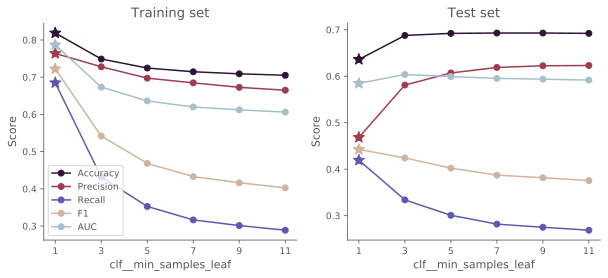

In [8]:
# baseline pipeline
baseline_pipe = init_pipe()

# parameters to change
try_params = {'clf__min_samples_leaf':[1,3,5,7,9,11]} # the default value is 1
train_scores, test_scores, pipes = multiparam_mansearch(try_params, X_train_sub, y_train_sub, X_test_sub, y_test_sub)
plot_scores_singleparam(try_params, baseline_pipe, train_scores, test_scores);

In the plot above, the **left** panel shows the performance metric scores for `X_train_sub`, while the **right** panel shows the scores for `X_test_sub`. Stars indicate the default value for `min_samples_leaf` (that is, if we just construct the default `ExtraTrees` model, leaf nodes require at least 1 sample).

Comparing the two panels, we can see that although this default setting performs best on the training set, we see some mixed results with the test set. Specifically, as we increase the minimum samples per leaf node, the accuracy and precision increase but the recall and F1-scores drop (AUC is roughly constant). 


---

In this case, it makes sense to prioritize **recall** over precision and accuracy -- the logic being that it would be more frustrating to expect your flight to be on-time and encounter delays than to expect a delayed flight and take off on-time. 

Recall decreases as we increase `min_samples_leaf` due to (or related to) the fact that we do not have balanced classes. During training, in order for any tree within the ExtraTrees ensemble to create a leaf node that will classify flights as delayed, that node needs to contain a *majority* of flights that are (really) delayed. And since delayed flights make up a minority of the dataset, the more samples we have in a given node the less likely it is that the majority are delayed (for example, consider an extreme cases where the entire dataset was in a node).

---

That was only one hyperparameter -- let's look at the number of samples required to split a node:

Setting parameters: {'clf__min_samples_split': 2}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.0s remaining:   51.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.0s remaining:   24.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__min_samples_split': 3}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.3s remaining:   52.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.9s remaining:   23.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__min_samples_split': 5}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.3s remaining:   48.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.4s remaining:   22.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished




Setting parameters: {'clf__min_samples_split': 7}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.6s remaining:   49.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.9s remaining:   20.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


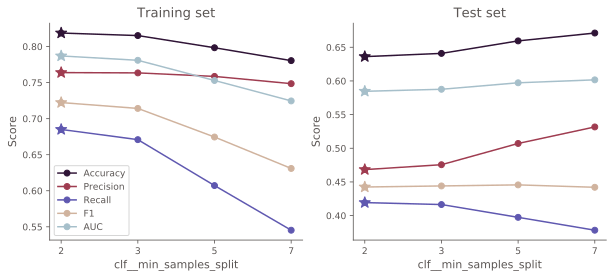

In [9]:
# parameters to change
try_params = {'clf__min_samples_split':[2,3,5,7]} # the default value is 2
train_scores, test_scores, pipes = multiparam_mansearch(try_params, X_train_sub, y_train_sub, X_test_sub, y_test_sub)
plot_scores_singleparam(try_params, baseline_pipe, train_scores, test_scores);

Similar to `min_samples_leaf`, when we increase the minimum number of samples required to *split* a node, Recall begins to drop (although less steeply this time). This is another way to limit the depth of the trees and set the minimum size of the leaf nodes (i.e., imagine a node with 6 samples that is split in half - if `min_samples_split=5` then we would end up with 2 leaf nodes with 3 samples each, because we could not split them again).

What happens if we change the maximum number of features that are considered at each node? 

Setting parameters: {'clf__max_features': 'auto'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.3s remaining:   48.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.1s remaining:   24.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__max_features': 2}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   13.8s remaining:   41.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   14.5s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.4s remaining:   25.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished




Setting parameters: {'clf__max_features': 3}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   22.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   23.2s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.9s remaining:   23.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished




Setting parameters: {'clf__max_features': 5}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   29.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   30.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.8s remaining:   23.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished


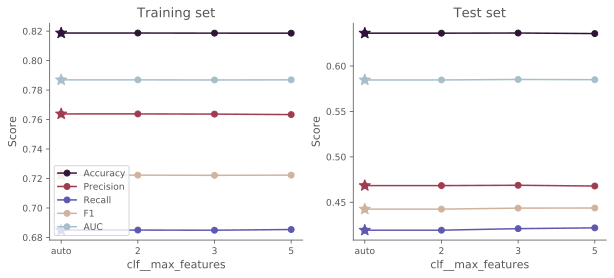

In [10]:
# parameters to change
try_params = {'clf__max_features':['auto',2,3,5]} # the default value is 'auto'
train_scores, test_scores, pipes = multiparam_mansearch(try_params, X_train_sub, y_train_sub, X_test_sub, y_test_sub)
plot_scores_singleparam(try_params, baseline_pipe, train_scores, test_scores);

Not much - none of the performance metrics are sensitive to the number of features considered at each node (possibly because we are sampling with replacement?)

Let's check out what happens when we change the class weights:

Setting parameters: {'clf__class_weight': 'balanced'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.9s remaining:   23.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__class_weight': 'balanced_subsample'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   22.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.1s remaining:   24.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__class_weight': None}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.8s remaining:   53.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.3s remaining:   25.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished


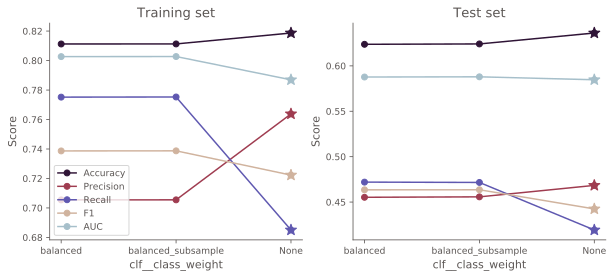

In [11]:
# parameters to change
try_params = {'clf__class_weight':['balanced','balanced_subsample',None]} # the default value is None
train_scores, test_scores, pipes = multiparam_mansearch(try_params, X_train_sub, y_train_sub, X_test_sub, y_test_sub)
plot_scores_singleparam(try_params, baseline_pipe, train_scores, test_scores);

At first glance, this plot seems to suggest that we should set `class_weight='Balanced` (or `Balanced_subsample`) rather than `None`, because these settings lead to higher recall scores. 

However, let's consider *why* that is happening. 

The `class_weight` parameter affects how information gain is calculated at each node (either with gini or entropy). The Gini Impurity with $n$ classes, for example, is:  
$$G =  \sum_{k=1}^{n} f_{k} (1 - f_{k}) = 1 - \sum_{k=1}^{n}f_{k}^{2}$$  
where $f_{k}$ is the fraction of samples belonging to class $k$ in the node. 

To compute $f_{k}$, we have the option of applying a class-based weighting scheme, as in:  
$$ f_{k} = \frac{w_{k}n_{k}}{\sum_{k=1}^{n}w_{k}n_{k}} $$  
where $w_{k}$ are the class weights. The numerator and denominator can then be understood as the weighted number of samples of class $k$ in the node and the weighted sum of total samples in the node, respectively.

If we "balance" the classes, we are effectively weighting them inversely by the size of the class. In other words, the minority class will become more important, and our ExtraTrees model has an easier time classifying flights as delayed (this is why recall goes up - but precision goes down). 

The effects of changing `class_weights` become clearer when we attempt to reproduce trends in the data, so we will return to this hyperparameter later in the notebook.

---

**<center><font size="4">Investigating multiple hyperparameters at once</font></center>**

While tuning individual hyperparameters helps us understand the effect of each one, it is also important to more fully explore hyperparameter-space by changing multiple at once.

Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   18.0s remaining:   54.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.1s remaining:   24.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.6s remaining:   52.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.0s remaining:   24.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   14.1s remaining:   42.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   14.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.7s remaining:   23.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.9s remaining:   53.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.1s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.3s remaining:   51.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.8s remaining:   14.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.0s remaining:   50.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.8s remaining:   14.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 8, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   12.2s remaining:   36.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.2s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.9s remaining:   20.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished




Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 8, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.5s remaining:   49.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   48.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.6s remaining:   16.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   13.1s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 4, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.2s remaining:   48.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.5s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 4, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.8s remaining:   17.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.6s remaining:   16.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.9s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.8s remaining:   17.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.1s remaining:   48.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   12.1s remaining:   36.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.6s remaining:   16.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   13.2s remaining:   39.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.0s remaining:   15.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.9s remaining:   47.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.0s remaining:   14.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 4, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.2s remaining:   48.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.4s remaining:   10.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 4, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.5s remaining:   46.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.2s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 6, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.4s remaining:   46.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 6, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.4s remaining:   46.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 8, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.8s remaining:   47.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 5, 'clf__min_samples_split': 8, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.2s remaining:   45.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.2s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 2, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.5s remaining:   46.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 2, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.1s remaining:   45.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 4, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.6s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.8s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 4, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.5s remaining:   46.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 6, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.5s remaining:   46.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 6, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.4s remaining:   46.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.5s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 8, 'clf__criterion': 'gini'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.6s remaining:   46.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.5s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.0s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished




Setting parameters: {'clf__min_samples_leaf': 7, 'clf__min_samples_split': 8, 'clf__criterion': 'entropy'}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   11.4s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished


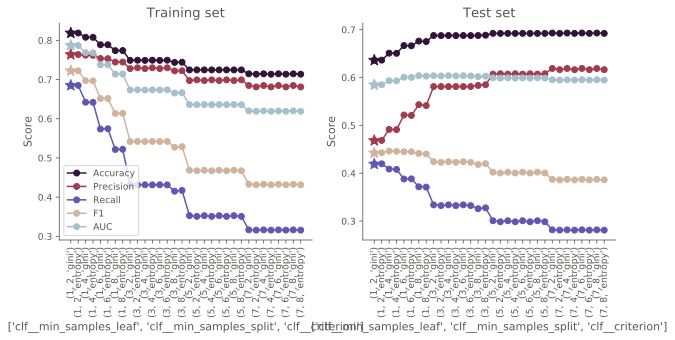

In [12]:
# parameters to change
try_params = {'clf__min_samples_leaf':[1,3,5,7], # default is 1
                     'clf__min_samples_split':[2,4,6,8], # default is 2
                     'clf__criterion':['gini','entropy']} # default is "gini"

train_scores, test_scores, pipes = multiparam_mansearch(try_params, X_train_sub, y_train_sub, X_test_sub, y_test_sub)
plot_scores_mangrid(try_params, baseline_pipe, train_scores, test_scores);

In the plot above, we can notice two things:

1. Our results are not sensitive to whether we use Entropy or the Gini Impurity as the criterion for splitting nodes. This can be most easily seen towards the left side of both panels - the pairs of points have identical values of `min_samples_leaf` and `min_samples_split` and only differ in the choice of `criterion` - but their scores are also identical (regardless of performance metric). 
2. Our intuition from individaul parameter tuning that changing `min_samples_leaf` has a larger effect than `min_samples_split` appears to be supported here as well. The largest drops in recall (in either panel) correspond to increases to `min_samples_leaf`.

---

**<center><font size="4">GridSearch with cross-validation</font></center>**

We also need to look into how robust our hyperparameters are to variations within the data. To do this, we can do a grid search with cross-validation.

The cell below defines some functions to do this:

In [13]:
from sklearn.model_selection import GridSearchCV
from datetime import datetime

def gridsearch(X_train, y_train, pipe, param_grid, cv=3,
                           scoring='recall', verbose=10, get_train_scores=False):
    
    """
    Wrapper around sklearn's GridSearchCV
    
    Parameters
    ----------
    X_train : DataFrame
        Features of the training set
        
    y_train : DataFrame
        Labels of the training set
        
    pipe : pipeline
        Configured pipeline (with fixed hyperparameters)
        
    param_grid : dict
        Dictionary containing names of parameters to adjust and which values to assign them
        
    cv : int
        Number of cross-validation folds
        
    scoring : str
        Scoring to use when evaluating each combination of model hyperparameters
        
    verbose : int
        Level of verbosity
        
    get_train_scores : bool
        If True, return the scores for the training set (default is test set only)
        
    Returns
    -------
    GridSearchCV results and a pipeline trained with the "best" scores
    
    """

    start_time = datetime.now()
    
    if verbose > 0:
        print('\nPerforming grid search .... ')
        print('Start time: %s' % str(start_time))
        
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring=scoring, 
                        return_train_score=get_train_scores, n_jobs=-1, verbose=verbose,
                        refit=False, pre_dispatch=2)

    grid.fit(X_train, y_train)
    end_time = datetime.now()
    delta_t = (end_time - start_time).total_seconds()/60.
    
    if verbose > 0:
        print('GridSearch+CV took: %s minutes' % delta_t)
        print('\nBest parameters are:', grid.best_params_)
        print('\nRefitting full training set with optimal parameters...')
    pipe.set_params(**grid.best_params_)
    pipe.fit(X_train, y_train)
    
    return grid, pipe

def compare_search_scores(grid, cv=3, model_type='extra trees'):
    """
    Visualize the results of GridSearchCV
    
    Parameters
    ----------
    grid : obj
        Results of the GridSearchCV
        
    cv : int
        Number of cross-validation folds
        
    model_type : str
        Description of the model
    """
    fig, ax = plt.subplots(1, 1, figsize=(8,4))

    for cv_ind in range(cv):
        if cv_ind == 0:
            ax.plot(grid.cv_results_['split%s_test_score' % cv_ind], '-o', color='k', label='cv-test')
            if 'split%s_train_score' % cv_ind in grid.cv_results_.keys():
                ax.plot(grid.cv_results_['split%s_train_score' % cv_ind], '--', color='grey', label='cv-train')
        else:
            ax.plot(grid.cv_results_['split%s_test_score' % cv_ind], '-o', color='k')
            if 'split%s_train_score' % cv_ind in grid.cv_results_.keys():
                ax.plot(grid.cv_results_['split%s_train_score' % cv_ind], '--', color='grey')
                
    plt.ylabel(grid.scoring)
    plt.xticks(range(len(grid.cv_results_['params'])),grid.cv_results_['params'], rotation=90)
    plt.legend(fontsize='small');

Let's see what happens if we change `min_samples_leaf` and `min_samples_split`. Note that here, we can use `X_train` and `y_train` directly because sklearn's `GridSearchCV` will split the data into (in this case) 3 folds for us.


Performing grid search .... 
Start time: 2021-01-10 21:11:50.421281
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 19.0min finished


GridSearch+CV took: 19.027823966666666 minutes

Best parameters are: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}

Refitting full training set with optimal parameters...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   23.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   24.5s finished


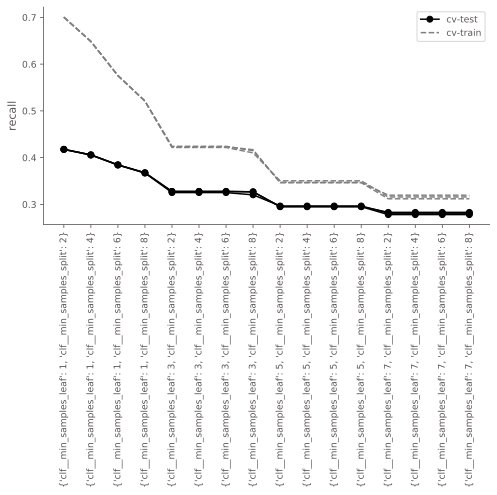

In [14]:
# parameters to change
gs_params = {'clf__min_samples_leaf':[1,3,5,7], # default is 1
             'clf__min_samples_split':[2,4,6,8]} # default is 2

# run grid search and then train the model with the best parameters
pipe_3folds = init_pipe()
grid_3folds, gs_pipe = gridsearch(X_train, y_train, pipe_3folds, gs_params, 
                             cv=3, scoring='recall', verbose=1, # scoring can be a LIST!
                             get_train_scores=True)

compare_search_scores(grid_3folds, cv=3, model_type='ExtraTrees');

Some good news - our hyperparameter results are not particularly sensitive to which subset of the data they work with! 

In the plot above, each grey dashed line represents one of the 3 training folds, and each solid black line represents a corresponding test fold. The folds are entirely overlapping for most combinations of hyperparameters, although the spread begins to increase slightly as we move to larger values of both `min_samples_leaf` and `min_samples_split`. 

---

Moving forward, we will use `min_samples_leaf=1` and `min_samples_split=2` (both of these are the default parameters).

---

**A short note on scoring choices**

The following is copied from sklearn's [documenation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#examples-using-sklearn-metrics-recall-score) for recall:
> **average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]**  
This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:  
* `binary`: Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.  
* `micro`: Calculate metrics globally by counting the total true positives, false negatives and false positives.  
* `macro`: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.  
* `weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.  
* `samples`: Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).  

Since we are dealing with a **binary classification** (only two classes, positive and negative, or delayed and not-delayed), we should use `average="binary"`. In other words, the recall will only be computed *for the positive class*. And if our priority is to identify delayed flights, this is what we care about the most. 

All of the other options for `average` are designed for multi-class problems and will return, well, an *average* of scores across either classes or datapoints. i.e., the score will be computed for *every* class. SO, while they can in principle be applied to a binary case, it means that class imbalance will cause the recall scores to be *inflated* by the negative class (the model has an easier time here because there are more examples to work with). So we probably should *not* apply them in this case.

When we do a grid search, this means passing the parameter `scoring="recall"` (any other option would have a suffix specifying which one to use; `"binary"` is the default).

---
**<center><font size="6">Training our final 2018 model</font></center>**

We're ready to train our model on the full 2018 training set!

In [15]:
# best hyperparams based on grid searching
param_dict = {'clf__min_samples_leaf':1, 'clf__min_samples_split':2, 'clf__class_weight':None}
print('Setting parameters: %s' % param_dict)
pipe2018 = init_pipe()
pipe2018.set_params(**param_dict)

# train on the full training set
pipe2018.fit(X_train, y_train)

Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__class_weight': None}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   26.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   27.6s finished


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('enc',
                                                                   OrdinalEncoder(categories='auto',
                                                                                  dtype=<class 'numpy.float64'>))],
                                                           verbose=False),
                                                  ['OP_UNIQUE_CARRIER'])],
                                   verbose=False)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                                      c

---
**<center><font size="6">Accuracy and beyond </font></center>**

How does our 2018 model perform? Let's start by looking at the confusion matrix for the training and test sets:

In [16]:
import matplotlib.gridspec as gridspec

def confusion_matrix(X_, y_, y_pred, pos_label='Positive', neg_label='Negative', data_label=''):
    """
    Create a confusion matrix
    
    Parameters
    ----------
    X_ : DataFrame
        Features of the data
        
    y_ : DataFrame
        Labels of the data
        
    y_pred : DataFrame
        Model predictions (model.predict(X_))
        
    pos_label : str
        Description of the positive class
        
    neg_label : str
        Description of the negative class
        
    data_label : str
        Optional additional description (e.g. "training set" or "test set")
        
    Returns
    -------
    A figure
    """
    cmap = pylab.cm.YlGnBu
    
    tot_P = len(y_[y_==1])
    tot_F = len(y_[y_==0])
    
    # --> change to neg / pos, assign labels as args. 

    f = plt.figure(figsize=(12,6))
    spec = gridspec.GridSpec(nrows=4, ncols=16)

    cm_ax = f.add_subplot(spec[1:3, 1:6])
    pos_pos, neg_pos = 0.25, 0.75

    hw = 0.25

    cm_ax.set_yticks([pos_pos, neg_pos])
    cm_ax.set_yticklabels(['Pred.\n%s' % pos_label, 'Pred.\n%s' % neg_label])
    cm_ax.set_xticks([pos_pos, neg_pos])
    cm_ax.set_xticklabels([pos_label, neg_label])
    cm_ax.set_title(data_label)

    # neg // classified neg
    TN = ((y_==0) & (y_pred==0)).sum()

    cm_ax.add_patch(pylab.Rectangle((neg_pos-hw, neg_pos-hw), 0.5, 0.5, 
                                    edgecolor='none', facecolor=cmap(TN/tot_F), alpha=0.75))
    cm_ax.text(neg_pos, neg_pos, '{}%'.format(np.around(100*TN/tot_F, 1)), 
               verticalalignment='center', horizontalalignment='center', color='k')

    # neg // classified pos
    FP = ((y_==0) & (y_pred==1)).sum()

    cm_ax.add_patch(pylab.Rectangle((neg_pos-hw, pos_pos-hw), 0.5, 0.5, 
                                    edgecolor='none', facecolor=cmap(FP/tot_F), alpha=0.75))
    cm_ax.text(neg_pos, pos_pos, '{}%'.format(np.around(100*FP/tot_F, 1)), 
               verticalalignment='center', horizontalalignment='center', color='k')

    # pos // classified pos
    TP = ((y_==1) & (y_pred==1)).sum()

    cm_ax.add_patch(pylab.Rectangle((pos_pos-hw, pos_pos-hw), 0.5, 0.5, 
                                    edgecolor='none', facecolor=cmap(TP/tot_P), alpha=0.75))
    cm_ax.text(pos_pos, pos_pos, '{}%'.format(np.around(100*TP/tot_P, 1)), 
               verticalalignment='center', horizontalalignment='center', color='k')

    # pos // classified neg
    FN = ((y_==1) & (y_pred==0)).sum()

    cm_ax.add_patch(pylab.Rectangle((pos_pos-hw, neg_pos-hw), 0.5, 0.5, 
                                    edgecolor='none', facecolor=cmap(FN/tot_P), alpha=0.75))
    cm_ax.text(pos_pos, neg_pos, '{}%'.format(np.around(100*FN/tot_P, 1)), 
               verticalalignment='center', horizontalalignment='center', color='k')
        
    return f

def predict_and_summarize(X_, y_, pipe, return_scores=False, label=''):
    y_pred = pipe.predict(X_)
    confusion_matrix(X_, y_, y_pred, pos_label='Delayed', neg_label='On-time', data_label=label);
    scores = summarize_results(y_, y_pred, return_scores=return_scores)
    if return_scores:
        return scores

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.3s remaining:   22.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.5s finished


Accuracy: 0.80
Precision: 0.74
Recall: 0.65
F1: 0.69
AUC: 0.76


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished


Accuracy: 0.64
Precision: 0.47
Recall: 0.42
F1: 0.45
AUC: 0.59


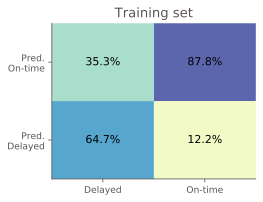

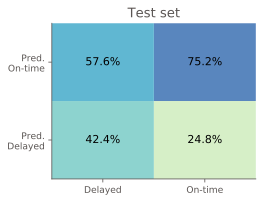

In [17]:
# evaluate on the training set and on the test set
predict_and_summarize(X_train, y_train, pipe2018, return_scores=True, label='Training set');
predict_and_summarize(X_test, y_test, pipe2018, return_scores=True, label='Test set');

Not surprisingly, the training set gets better results, with 65% of delayed flights getting correctly classified as delayed (and 88% of on-time flights correctly classified as on-time). 

For the test set, however, we only correctly classify 42% and 75% of delayed and on-time flights, respectively. (Note: these percentages are normalized by their real labels). 

---

For a closer look at what the recall (and precision, etc) mean, we can vary the decision threshold. By default, the threshold is 0.5; that is, any flight with a probability of being delayed that is greater than 0.5 is classified as delayed. These probabilities are the mean result from each individual tree in the ensemble.

If we change the threshold, then, we also change the classification:

In [18]:
# predicted class probabilities (mean result from all the individual trees in the forest)
probs_train = pipe2018.predict_proba(X_train)
probs_test = pipe2018.predict_proba(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   11.5s remaining:   34.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   11.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.8s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished


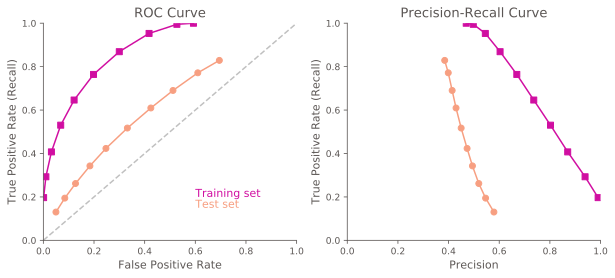

In [19]:
fpr_train, tpr_train, prec_train = [],[],[]
fpr_test, tpr_test, prec_test = [],[],[]

for thresh in np.arange(0.0,1.0,0.1):
    # train
    tp_train = len(y_train[(probs_train[:,1] > thresh) & (y_train==1)])
    fp_train = len(y_train[(probs_train[:,1] > thresh) & (y_train==0)])
    tn_train = len(y_train[(probs_train[:,1] <= thresh) & (y_train==0)])
    fn_train = len(y_train[(probs_train[:,1] <= thresh) & (y_train==1)])
    
    # test
    tp_test = len(y_test[(probs_test[:,1] > thresh) & (y_test==1)])
    fp_test = len(y_test[(probs_test[:,1] > thresh) & (y_test==0)])
    tn_test = len(y_test[(probs_test[:,1] <= thresh) & (y_test==0)])
    fn_test = len(y_test[(probs_test[:,1] <= thresh) & (y_test==1)])
    
    tpr_train.append(tp_train/(tp_train+fn_train))
    fpr_train.append(fp_train/(tn_train+fp_train))
    prec_train.append(tp_train/(tp_train+fp_train))
    
    tpr_test.append(tp_test/(tp_test+fn_test))
    fpr_test.append(fp_test/(tn_test+fp_test))
    prec_test.append(tp_test/(tp_test+fp_test))
    
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--', color='silver')
axes[0].plot(fpr_train, tpr_train, '-s', color='#D00EA1')
axes[0].plot(fpr_test, tpr_test, '-o', color='#F79F81')
axes[0].set_title('ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate (Recall)')
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].text(0.6,0.2,'Training set', color='#D00EA1')
axes[0].text(0.6,0.15,'Test set', color='#F79F81');

axes[1].plot(prec_train, tpr_train, '-s', color='#D00EA1')
axes[1].plot(prec_test, tpr_test, '-o', color='#F79F81')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Precision')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1);

In the plot above, the **left panel** shows the ROC curve. The area under this curve is the AUC scoring parameter, and better models will have higher AUC scores (with points closer to the top left corner of the plot). For comparison, the grey 1:1 line shows what the curve would look like with random classifications.

In the **right panel** we show the precision-recall curve, where it becomes clear that there is a trade-off betwen the two. Interestingly, the trade-off appears more dramatic in the training set, but this may just be because precision is capped at a lower score for the test set. 

In principle, if we *really* only care about identifying all the delayed flights, we could lower the decision threshold and classify more flights as delayed (which would increase recall and lower precision). But at a certain point, we may as well just build a model that says every flight is likely to be delayed, and this would be pretty useless.

---
**<center><font size="6">Assessing feature importance</font></center>**

Which features are more important to the model? There are two ways of exploring this question, and we will try both.

---

**<center><font size="4">Mean Decrease in Impurity (MDI)</font></center>**

In sklearn, decision trees actually have an attribute called `feature_importances_` which provides impurity-based feature importances. It is an estimate for the total information gain (calculated via a decrease in either gini impurity or in entropy) in a given node due to a particular feature. The higher the number, the more important the feature.

We can take a look at the results for our 2018 model:

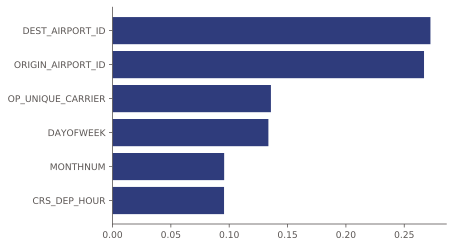

In [20]:
# sort features 
ft_names = np.array(features)
mdi_importance = pipe2018.named_steps['clf'].feature_importances_
sorted_idx = mdi_importance.argsort()[::-1]

fig, ax = plt.subplots()
y_ticks = range(0,len(ft_names))[::-1]

ax.barh(y_ticks, mdi_importance[sorted_idx], color='#2F3C7C')
ax.set_yticklabels(ft_names[sorted_idx])
ax.set_yticks(y_ticks);

The values above were calculated from the training set. According to this plot, the most important features (by quite a bit) are the destination and origin airport, followed by the airline and day of the week. The month and departure time are considered relatively unimportant.

This raises some... skepticism.. because our exploratory data analysis showed that time of day and month were both pretty important.

Sklearn's documentation warns, however, that MDI performs poorly for features with high cardinality (as is the case for several of our features). Furthermore, the importance of a feature depends on when it shows up in the tree (ie earlier splits tend to lead to more significant information gains), and since our ExtraTrees model randomly selects features at each node, feature importance could easily be under- or over-estimated.

---

**<center><font size="4">Permutation importance</font></center>**

Our second option is permutation importance. In this case, a performance metric (for our `pipe2018` model, this is recall) is computed as a baseline. Then, each feature is permutated (with the others kept fixed) and the scores are computed again. This process is repeated `n_repeats` times (we will use 50 in this case). The result is a list of  differences (between the permutated and baseline scores) for each feature. The greater the difference, the more important the feature:

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.9s remaining:   11.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.0s finished


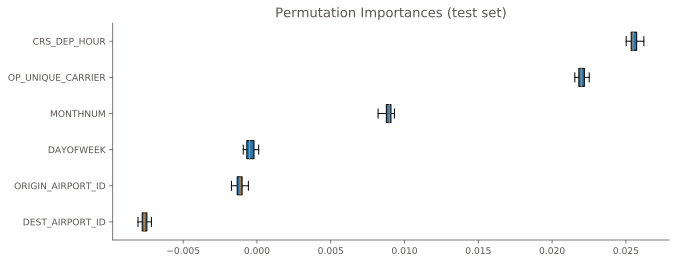

In [21]:
from sklearn.inspection import permutation_importance
import gc

gc.collect()

result = permutation_importance(pipe2018, X_test, y_test, n_repeats=50, random_state=0, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx], whis=(1,99))
ax.set_title("Permutation Importances (test set)");

In the boxplot above, orange lines show the average difference in recall resulting from permutating each feature; the whiskers span the $1^{\rm st}-99^{\rm th}$ percentiles.

Unlike MDI, the permutation importances *are* closely aligned with what we saw during our [exploratory data analysis](https://nbviewer.jupyter.org/github/atmerritt/delay-expectations/blob/scribbles/flight_delays_data_explore.ipynb?flush_cache=true). For example: 
* `CRS_DEP_HOUR` is now the most important feature (expected; this is where we saw the strongest trends)
* `OP_UNIQUE_CARRIER` is the 2nd most important, followed by `MONTHNUM` in 3rd place. These scored much lower according to MDI, but we could see a lot of structure in the feature grids.

---
**<center><font size="6">How well does our model capture trends in the 2018 data?</font></center>**

To see whether (or how well) our model has managed to reproduce the tends in the 2018 data that we saw during the exploratory data analysis, we need to generate predictions on our test dataset. We'll also compute the predicted class probabilities (for each flight, this is the average of the probabilities assigned by each individual tree):

In [22]:
preds = pipe2018.predict(X_test)
probas = pipe2018.predict_proba(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.3s remaining:    9.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.8s remaining:   11.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished


It's also important to compare to a "dummy" classifier, to make sure we're really gaining something from using our model. The key thing here is that the dummy classifier does not actually see `X_train` at all, and therefore its predictions have nothing to do with the features in the training set. We'll use a stratified `DummyClassifier`, which assigns classes that reflect the label distribution in `y_train`:

In [23]:
from sklearn.dummy import DummyClassifier
dummy_pred = DummyClassifier(strategy="stratified", random_state=0).fit(X_train, y_train).predict(X_test)

The cell below defines code to display trends in the data and compare the true labels to the 2018 model and the dummy model:

/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


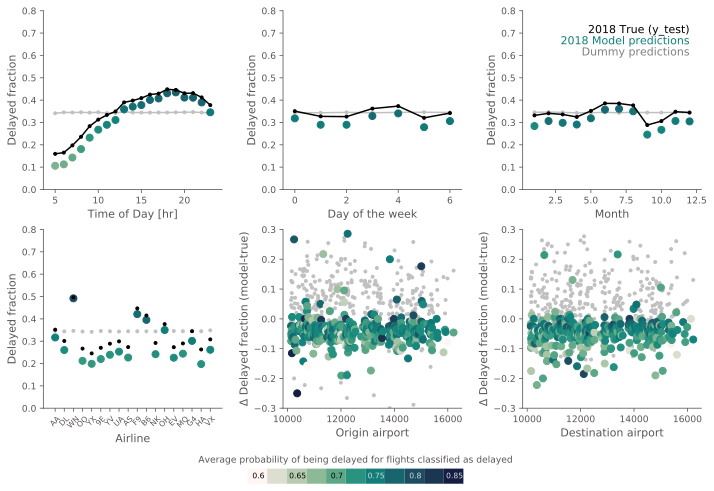

In [24]:
import matplotlib.patches as patches

import cmocean

def plot_trends(X_, y_, pred, probs, dummy=None, dataset='2018'):
    """
    Visualize trends in the data, and model performance
    
    Parameters
    ----------
    X_ : DataFrame
        Features of the data
        
    y_ : DataFrame
        Labels of the data
        
    pred : DataFrame
        Model predictions (model.predict(X_))
        
    probs : DataFrame
        Model predicted probabilities (model.predict_proba(X_))
        
    dummy : None, or model obj
        Optionally provide a "dummy" model for comparison
        
    dataset : str
        Specify which dataset (2018, 2019, 2020) we are trying to classify
        
    Returns
    -------
    A figure
    """
  
    # hours of the day (5am-midnight)
    hrs = range(5,24)
    fdelay_hourly_ytest = [y_[X_['CRS_DEP_HOUR']==hr].mean() for hr in hrs]
    fdelay_hourly_model = [pred[X_['CRS_DEP_HOUR']==hr].mean() for hr in hrs]
    #meanprob_hourly_model = [probs[X_['CRS_DEP_HOUR']==hr, 1].mean() for hr in hrs]
    meanprob_hourly_model = [probs[(X_['CRS_DEP_HOUR']==hr) & (pred==1), 1].mean() for hr in hrs]
    
    # day of the week
    days = range(0,7)
    fdelay_daily_ytest = [y_[X_['DAYOFWEEK']==day].mean() for day in days]
    fdelay_daily_model = [pred[X_['DAYOFWEEK']==day].mean() for day in days]
    #meanprob_daily_model = [probs[X_['DAYOFWEEK']==day, 1].mean() for day in days]
    meanprob_daily_model = [probs[(X_['DAYOFWEEK']==day) & (pred==1), 1].mean() for day in days]

    
    # month
    months = range(1,13)
    fdelay_monthly_ytest = [y_[X_['MONTHNUM']==month].mean() for month in months]
    fdelay_monthly_model = [pred[X_['MONTHNUM']==month].mean() for month in months]
    #meanprob_monthly_model = [probs[X_['MONTHNUM']==month, 1].mean() for month in months]
    meanprob_monthly_model = [probs[(X_['MONTHNUM']==month) & (pred==1), 1].mean() for month in months]

    
    # airline
    airlines = X_['OP_UNIQUE_CARRIER'].unique()
    fdelay_airlines_ytest = [y_[X_['OP_UNIQUE_CARRIER']==airline].mean() for airline in airlines]
    fdelay_airlines_model = [pred[X_['OP_UNIQUE_CARRIER']==airline].mean() for airline in airlines]
    #meanprob_airlines_model = [probs[X_['OP_UNIQUE_CARRIER']==airline, 1].mean() for airline in airlines]
    meanprob_airlines_model = [probs[(X_['OP_UNIQUE_CARRIER']==airline) & (pred==1), 1].mean() for airline in airlines]

    
    # airports
    orig_airports = np.sort(X_['ORIGIN_AIRPORT_ID'].unique())
    fdelay_orig_ytest = np.array([y_[X_['ORIGIN_AIRPORT_ID']==airport].mean() for airport in orig_airports])
    fdelay_orig_model = np.array([pred[X_['ORIGIN_AIRPORT_ID']==airport].mean() for airport in orig_airports])
    #meanprob_orig_model = np.array([probs[X_['ORIGIN_AIRPORT_ID']==airport, 1].mean() for airport in orig_airports])
    meanprob_orig_model = np.array([probs[(X_['ORIGIN_AIRPORT_ID']==airport) & (pred==1), 1].mean() for airport in orig_airports])

    dest_airports = np.sort(X_['DEST_AIRPORT_ID'].unique())
    fdelay_dest_ytest = np.array([y_[X_['DEST_AIRPORT_ID']==airport].mean() for airport in dest_airports])
    fdelay_dest_model = np.array([pred[X_['DEST_AIRPORT_ID']==airport].mean() for airport in dest_airports])
    #meanprob_dest_model = np.array([probs[X_['DEST_AIRPORT_ID']==airport, 1].mean() for airport in dest_airports])
    meanprob_dest_model = np.array([probs[(X_['DEST_AIRPORT_ID']==airport) & (pred==1), 1].mean() for airport in dest_airports])

    
    fig, axes = plt.subplots(2,3, figsize=(10,7))
    cmap = cmocean.cm.tempo
    vmin, vmax = 0.6, 0.85
    
    # time of day
    axes[0,0].set_xlabel('Time of Day [hr]')
    axes[0,0].set_ylabel('Delayed fraction')
    axes[0,0].plot(hrs,fdelay_hourly_ytest, '-o', ms=3, color='k')
    sc = axes[0,0].scatter(hrs, fdelay_hourly_model, c=meanprob_hourly_model, 
                           cmap=cmap, s=50, vmax=vmax, vmin=vmin)
    axes[0,0].set_ylim(0,0.8)
    
    # day
    axes[0,1].set_xlabel('Day of the week')
    axes[0,1].set_ylabel('Delayed fraction')
    axes[0,1].plot(days, fdelay_daily_ytest, '-o', ms=3, color='k')
    axes[0,1].scatter(days, fdelay_daily_model, c=meanprob_daily_model, 
                      cmap=cmap, s=50, vmax=vmax, vmin=vmin)
    axes[0,1].set_ylim(0,0.8)
    
    # month
    axes[0,2].set_xlabel('Month')
    axes[0,2].set_ylabel('Delayed fraction')
    axes[0,2].plot(months, fdelay_monthly_ytest, '-o', ms=3, color='k')
    axes[0,2].scatter(months, fdelay_monthly_model, c=meanprob_monthly_model, 
                      cmap=cmap, s=50, vmax=vmax, vmin=vmin)
    axes[0,2].set_ylim(0,0.8)
    axes[0,2].text(12,0.7, '{} True (y_test)'.format(dataset), color='k', horizontalalignment='right')
    axes[0,2].text(12,0.65, '2018 Model predictions', color=cmap(0.6), horizontalalignment='right')
    
    # airline
    axes[1,0].set_xlabel('Airline')
    axes[1,0].set_ylabel('Delayed fraction')
    axes[1,0].plot(airlines,fdelay_airlines_ytest, 'o', ms=3, color='k')
    axes[1,0].scatter(airlines, fdelay_airlines_model, c=meanprob_airlines_model, 
                      cmap=cmap, s=50, vmax=vmax, vmin=vmin)
    axes[1,0].set_ylim(0,0.8)
    axes[1,0].tick_params(axis='x', labelrotation = 45, labelsize='x-small')

    
    # origin airport
    axes[1,1].set_xlabel('Origin airport')
    axes[1,1].set_ylabel(r'$\Delta$'+' Delayed fraction (model-true)')
    axes[1,1].scatter(orig_airports, fdelay_orig_model - fdelay_orig_ytest, c=meanprob_orig_model, 
                      cmap=cmap, s=50, vmax=vmax, vmin=vmin)
    axes[1,1].set_ylim(-0.3,0.3)

    
    # destination airport
    axes[1,2].set_xlabel('Destination airport')
    axes[1,2].set_ylabel(r'$\Delta$'+' Delayed fraction (model-true)')
    axes[1,2].scatter(dest_airports, fdelay_dest_model - fdelay_dest_ytest, c=meanprob_dest_model, 
                      cmap=cmap, s=50, vmax=vmax, vmin=vmin)
    axes[1,2].set_ylim(-0.3,0.3)
    
    fig.tight_layout(h_pad=1)
    
    fig.subplots_adjust(bottom=0.18)
    colorleg = fig.add_axes([0.35,0.03,0.3,0.03])
    colorleg.set_title('Average probability of being delayed for flights classified as delayed', fontsize='small')
    color_range = np.arange(vmin,vmax+0.025,0.025)
    n_boxes = len(color_range)
    for i,avgp in enumerate(color_range):
        colorleg.add_patch(patches.Rectangle((i*(1/n_boxes),0), (1/n_boxes), 1, facecolor=sc.to_rgba(avgp)))
        if i <= 5:
            pcolor = 'k'
        else:
            pcolor = 'gainsboro'
            
        if i % 2 == 0:
            colorleg.text(i*(1/n_boxes)+0.05, 0.5, str(np.around(avgp,2)), 
                          horizontalalignment='center',verticalalignment='center', fontsize='x-small', color=pcolor)
    colorleg.set_axis_off()
    
    if dummy is not None:
        fdelay_hourly_dummy = [dummy[X_['CRS_DEP_HOUR']==hr].mean() for hr in hrs]
        fdelay_daily_dummy = [dummy[X_['DAYOFWEEK']==day].mean() for day in days]
        fdelay_monthly_dummy = [dummy[X_['MONTHNUM']==month].mean() for month in months]
        fdelay_airlines_dummy = [dummy[X_['OP_UNIQUE_CARRIER']==airline].mean() for airline in airlines]
        fdelay_orig_dummy = np.array([dummy[X_['ORIGIN_AIRPORT_ID']==airport].mean() for airport in orig_airports])
        fdelay_dest_dummy = np.array([dummy[X_['DEST_AIRPORT_ID']==airport].mean() for airport in dest_airports])
        
        axes[0,0].plot(hrs, fdelay_hourly_dummy, '-o', ms=3, color='silver', zorder=0)
        axes[0,1].plot(days, fdelay_daily_dummy, '-o', ms=3, color='silver', zorder=0)
        axes[0,2].plot(months, fdelay_monthly_dummy, '-o', ms=3, color='silver', zorder=0)
        axes[1,0].plot(airlines, fdelay_airlines_dummy, 'o', ms=3, color='silver', zorder=0)
        axes[1,1].plot(orig_airports, fdelay_orig_dummy - fdelay_orig_ytest, 'o', ms=3, color='silver', zorder=0)
        axes[1,2].plot(dest_airports, fdelay_dest_dummy - fdelay_dest_ytest, 'o', ms=3, color='silver', zorder=0)
        
        axes[0,2].text(12,0.6, 'Dummy predictions', color='grey', horizontalalignment='right')

    
    return fig

plot_trends(X_test, y_test, preds, probas, dummy=dummy_pred);

---

*How to read this plot*:
* In each panel, the **<font size="3">black points</font>** show the true delayed fractions (i.e., calculated using `y_test`); the **<span style="color:#939594"><font size="3">grey points</font></span>** show predictions from the "dummy" model; and the **<span style="color:#518E5F"><font size="3">larger colored points</font></span>** show predictions from our 2018 model.
* For the 2018 model, the color of the points gives a sense of how "confident" the model is about its predictions. More concretely, the color indicates the average probability of being delayed -- for flights that our model *classifies as delayed*. These averages are calculated from the predictions of the individual trees.
* Every panel shows the fraction of flights that are delayed in a given feature bin (for example, in the top left: the fraction of flights that are delayed in various time bins). Note, however, that due to the large number of distinct airports, the lower middle and right panels show the *difference* between the two models and the true labels.

---

From the plot above, we can learn a few things:
1. Although our model (greenish points) generally underpredicts the fraction of delayed flights (i.e., it tends to missclassify delayed flights as on-time), it is able to capture the behavior and trends that we observe in the data (black points). In other words, even though our predictions are sometimes wrong, we are wrong "uniformly" across features rather than missing particular subsets of delayed flights.
2. When our model classifies a flight as delayed, it generally does so at the 75% probability level. However, as we can see from the colors of the points, there are some feature bins where the model is more "confident" in its choices than the average. 
    * For example, at 5am, the average probability of being delayed (for flights classified as delayed) is 68%, whereas at 7pm it is 78% (upper left panel). A similar effect can be seen for airlines (lower left panel), with flights classified as delayed having, on average, 80% probability of being delayed for Southwest Airlines (WN) and 72% for Hawaiian Airlines (HA). 
    * This is likely related to the fact that there are *more* delayed flights later in the day and/or associated with specific airlines, so it is easier to establish "delayed" nodes within these regions of feature-space. However, it is interesting that the differences in average probabilities are not very large.
3. Our model significantly outperforms the "dummy" model, which is unable to reproduce any trends in the features.

---

Another way to assess the behavior of our model is to look at how well we continue to reproduce the trends as we change the hyperparameters of the model.

The code below sets up a function to calculate and visualize this:

In [25]:
def plot_trends_hyperparams(X_test, y_test, base_pipe, leaf_pipes, split_pipes):
    """
    Visualize effect of changing hyperparameters
    
    Parameters
    ----------
    X_test : DataFrame
        Features of the data
        
    y_test : DataFrame
        Labels of the data
        
    base_pipe : pipeline
        The official / baseline pipeline
    
    leaf_pipes : list
        List of pipelines associated with various values of min_samples_leaf
        
    split_pipes : list 
        List of pipelines associated with various values of min_samples_split
        
    Returns
    -------
    A figure
    """
    # aesthetics
    cmap_leaf = pylab.cm.Blues_r
    cmap_split = pylab.cm.Oranges_r

    # range of hours
    hrs = range(5,24)
    fdelay_ytest = [y_test[X_test['CRS_DEP_HOUR']==hr].mean() for hr in hrs] # true

    base_pipe.set_params(**{'clf__verbose':0})
    pred_baseline = base_pipe.predict(X_test) # predicted using baseline model
    fdelay_base = [pred_baseline[X_test['CRS_DEP_HOUR']==hr].mean() for hr in hrs]

    fig, axes = plt.subplots(1,2,figsize=(10,4))
    axes[0].plot(hrs,fdelay_ytest, '-o',color='k', label='True (y_test)')
    axes[1].plot(hrs,fdelay_ytest, '-o',color='k', label='True (y_test)')
    axes[0].plot(hrs,fdelay_base, '-o', color='silver', label='2018 model (X_test)')
    axes[1].plot(hrs,fdelay_base, '-o', color='silver', label='2018 model (X_test)')

    for ind,trainedpipe in enumerate(leaf_pipes):
        trainedpipe.set_params(**{'clf__verbose':0})
        pred_pipe = trainedpipe.predict(X_test_sub)
        fdelay_subpred = [pred_pipe[X_test_sub['CRS_DEP_HOUR']==hr].mean() for hr in hrs]
        axes[0].plot(hrs,fdelay_subpred, '-o', color=cmap_leaf((ind+3)/(len(leaf_pipes)+5)), lw=1,ms=3, label='test')

    for ind,trainedpipe in enumerate(split_pipes):
        trainedpipe.set_params(**{'clf__verbose':0})
        pred_pipe = trainedpipe.predict(X_test_sub)
        fdelay_subpred = [pred_pipe[X_test_sub['CRS_DEP_HOUR']==hr].mean() for hr in hrs]

        if ind == 0:
            axes[1].plot(hrs,fdelay_subpred, '-o', color=cmap_split((ind+3)/(len(split_pipes)+5)), 
                         lw=1,ms=3, label='Adjusted model (X_test_sub)')
        else:
            axes[1].plot(hrs,fdelay_subpred, '-o', color=cmap_split((ind+3)/(len(split_pipes)+5)),lw=1,ms=3)    

    axes[0].set_title('min_samples_leaf')
    axes[0].set_ylabel('Fraction of delayed flights')
    axes[0].set_xlabel('Time of day')
    axes[0].set_ylim(0,0.8)
    axes[0].set_xticks(hrs)

    axes[1].set_title('min_samples_split')
    axes[1].set_ylabel('Fraction of delayed flights')
    axes[1].set_xlabel('Time of day')
    axes[1].set_ylim(0,0.8)
    axes[1].set_xticks(hrs)
    plt.legend(fontsize='small', frameon=False);
    return fig

We'll change two hyperparameters (individually, so we can more easily understand their effects) -- `min_samples_leaf` and `min_samples_split`:

Setting parameters: {'clf__min_samples_leaf': 1}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.4s remaining:   49.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.0s remaining:   24.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished




Setting parameters: {'clf__min_samples_leaf': 2}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   48.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.6s remaining:   19.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished




Setting parameters: {'clf__min_samples_leaf': 3}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.5s remaining:   46.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 5}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.5s remaining:   46.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 9}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   14.9s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.4s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   12.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished




Setting parameters: {'clf__min_samples_split': 2}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.7s remaining:   50.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.5s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.0s remaining:   24.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__min_samples_split': 4}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.3s remaining:   51.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.9s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.7s remaining:   23.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished




Setting parameters: {'clf__min_samples_split': 6}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   12.4s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.2s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.1s remaining:   21.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished




Setting parameters: {'clf__min_samples_split': 10}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.5s remaining:   49.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.4s remaining:   19.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished




Setting parameters: {'clf__min_samples_split': 20}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.3s remaining:   48.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.5s remaining:   16.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished


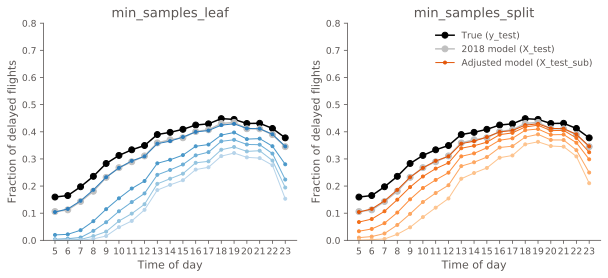

In [26]:
# parameters to change
leaf_params = {'clf__min_samples_leaf':[1,2,3,5,9]} # the default value is 1
train_scores, test_scores, leaf_pipes = multiparam_mansearch(leaf_params, 
                                                            X_train_sub, y_train_sub, 
                                                            X_test_sub, y_test_sub)

split_params = {'clf__min_samples_split':[2,4,6,10,20]} # the default value is 2
train_scores, test_scores, split_pipes = multiparam_mansearch(split_params, 
                                                                X_train_sub, y_train_sub, 
                                                                X_test_sub, y_test_sub)

plot_trends_hyperparams(X_test, y_test, pipe2018, leaf_pipes, split_pipes);

---

*How to read this plot*:
* The **<font size="3">black points</font>** show the true delayed fractions (i.e., calculated using `y_test`) as a function of time of day, and the **<span style="color:#939594"><font size="3">grey points</font></span>** show predictions from the 2018 model (using `X_test`; this effectively reproduces what we saw in the upper left panel of the previous plot). 
* The **<span style="color:#4370DA"><font size="3">blue curves</font></span>** in the left panel show the effect of adjusting the value of `min_samples_leaf` within our model (with all other hyperparameters unchanged). These predictions are calculated with `X_train_sub`, since we once again need to avoid using our test set for hyperparameter tuning.
* The **<span style="color:#FF8423"><font size="3">orange curves</font></span>** in the right panel show the same, but with adjusted values of `min_samples_split` instead.

---

We can see that as we increase the value of either `min_samples_leaf` or `min_samples_split` we missclassify more and more of the flights as on-time. This is not surprising, as it is another way of visualizing the decline in recall as we change those parameters (shown in several previous plots). 

What *is* new here is that now we know that, to zeroth order at least, changing these values does *not* affect our model's ability to reproduce the trends in the data. Instead, even though model's performance drops, it drops uniformly across feature-space. 

---
**<center><font size="6">Applications to 2019 data</font></center>**

We can ask our model to generalize even further by classifying 2019 data!

In the cell below, we define a function to quickly read in a year's worth of data and do some initial pre-processing:

In [27]:
def prep_datasets(year):
    """
    Read in data and do some light prep work
    
    Parameters
    ----------
    year : int
        2018, 2019 or 2020
        
    Returns
    -------
    X_train, X_test, y_train, y_test
    """
    
    # read in the data; drop a useless column
    df = pd.read_csv(os.path.join(data_folder, '{}_flights.csv'.format(year))).drop(columns=['Unnamed: 0'])

    # set target threshold
    df['IS_LATE'] = df['DEP_DELAY'].apply(lambda x: flag_me(x))

    features = ['CRS_DEP_HOUR', 'DAYOFWEEK', 'MONTHNUM',  
                'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
    target = ['IS_LATE']

    # convert string to int
    df['CRS_DEP_HOUR'] = df['CRS_DEP_HOUR'].astype(int)

    # drop cancelled flights AND flights before 5am
    df = df.loc[(df['CANCELLED']==False) & (df['CRS_DEP_HOUR'] >= 5),features+target]

    # define training and test sets
    X = df[features]
    y = df[target].values.reshape(-1,)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)
    return X_train, X_test, y_train, y_test

X_train19, X_test19, y_train19, y_test19 = prep_datasets(2019)

Now, we'll use our 2018 model to classify data from 2019:

/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


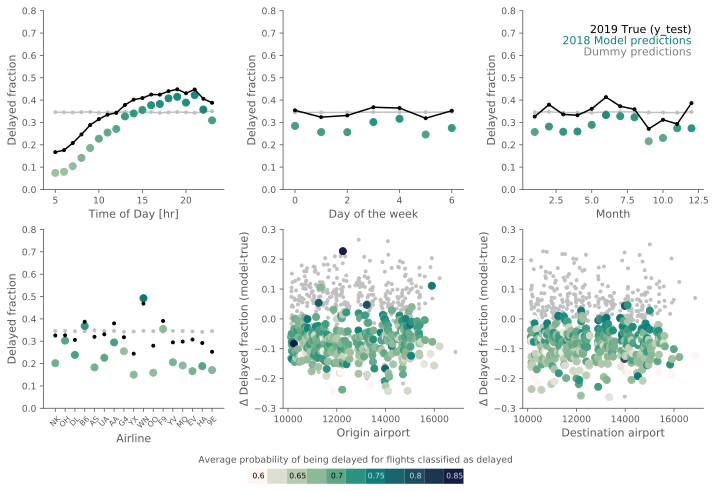

In [28]:
# get predictions and probabilities for each class:
preds19 = pipe2018.predict(X_test19)
probas19 = pipe2018.predict_proba(X_test19)

# create a dummy model for comparison
dummy_pred19 = DummyClassifier(strategy="stratified", random_state=0).fit(X_train19, y_train19).predict(X_test19)

# plot trends with various features
plot_trends(X_test19, y_test19, preds19, probas19, dummy=dummy_pred19, dataset='2019');

Once again, we can notice a few things about these plots:
1. Our model generalizes well enough to (roughly) capture some of the trends with features in the 2019 data (shown in **<font size="3">black points</font>**), such as the increasing delayed fraction over the course of the day or week, and even manages to capture *some* of the (different!) trends with airlines.
2. Once again, we outperform the "dummy" model (**<span style="color:#939594"><font size="3">grey points</font></span>**).
3. However, overall the difference between our model and the data is larger in 2019, across all features. 
4. Related, if we compare the **<span style="color:#518E5F"><font size="3">colors of the points</font></span>** in this plot to the 2018 data plot, we can see that in general the model is less "confident" here, with consistently lower average probabilities assigned to delayed flights.

---
**<center><font size="6">2020 breaks everything</font></center>**

Let's do the same exercise for 2020:

/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/envs/dfdev/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/anaconda2/envs/dfdev/l

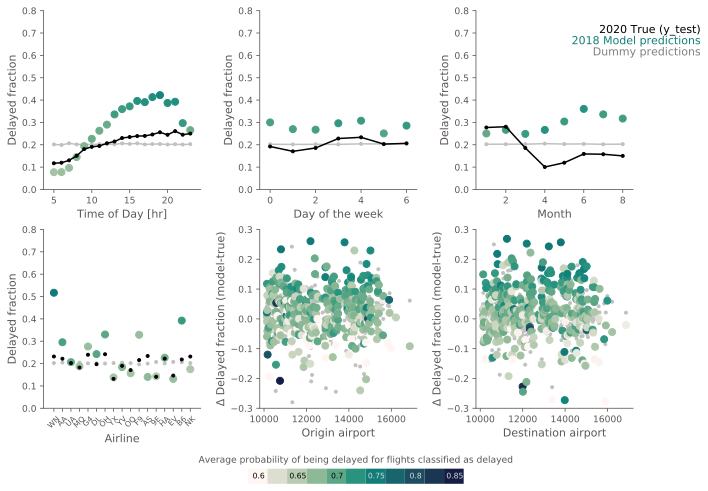

In [29]:
# read in 2020 data
X_train20, X_test20, y_train20, y_test20 = prep_datasets(2020)

# get predictions and probabilities for each class:
preds20 = pipe2018.predict(X_test20)
probas20 = pipe2018.predict_proba(X_test20)

# create a dummy model for comparison
dummy_pred20 = DummyClassifier(strategy="stratified", random_state=0).fit(X_train20, y_train20).predict(X_test20)

# plot trends with various features
plot_trends(X_test20, y_test20, preds20, probas20, dummy=dummy_pred20, dataset='2020');

Not surprisingly, 2020 is a mess. Almost none of the trends are reproduced -- the one (possible) exception being day of the week, although we are *overpredicting* the delayed fractions for every day. In fact, it appears that we are not actually gaining anything by using our model over the "dummy" model in this case!

Unlike the previous datasets, one of the main issues in general with our model performance in 2020 is an overestimation of the fraction of delayed flights. 2020 had relatively few delayed flights -- but of course it also had far fewer flights in total as well. This is likely the critical detail, because, as we learned during the data exploration exercise, one of the main drivers of the increasing fraction of delayed flights over the course of the day is the cumulation of small delays for late incoming flights.

---
**<center><font size="6">Takeaway #1: We're doing alright, but not great.</font></center>**

In summary -- our model is certainly not perfect, but it does provide *some* insight. In addition to outperforming the "dummy" model, we can make some relative statements with our model (albeit with large error bars, including the systematic error of underestimating delayed fractions).

For example, we know that certain times of day, certain months of the year, and certain airlines are *more likely* to produce delayed flights. 

If we check the probability of a delayed departure for a Southwest flight that leaves in the evening during the summer:

In [30]:
def prob_of_delay(pipe, flight_details, columns=None):
    """
    Generate a prediction for a flight using our model
    
    Parameters
    ----------
    pipe : pipeline
        The trained model pipeline
        
    flight_details : list or array
        Features of the flight in question
        
    columns : list
        List of feature names
        
    Returns
    -------
    The probability that the flight is delayed, according to the model
    """
    X = pd.DataFrame(data=flight_details, columns=columns)
    probas = pipe.predict_proba(X)
    return probas[:,1]

prob_of_delay(pipe2018, [[19,6,7,'WN',12889,10693]], columns=X_test.columns)

array([0.7202381])

Our model suggests that there is a 72% chance that this flight will be delayed. Of course, this is no guarantee that the flight really will be delayed, but it is statistically more likely than, say, a United Airlines flight that leaves in the morning during the spring:

In [31]:
prob_of_delay(pipe2018, [[8,1,4,'UA',12892,13930]], columns=X_test.columns)

array([0.125])

However, we should remember that the overall performance of the model is not exactly stellar -- as we saw earlier, our model's recall is only 43% and 75% for delayed and on-time flights, respectively. 

Sooo, while this was a fun exercise, these results should probably not be taken super seriously. 

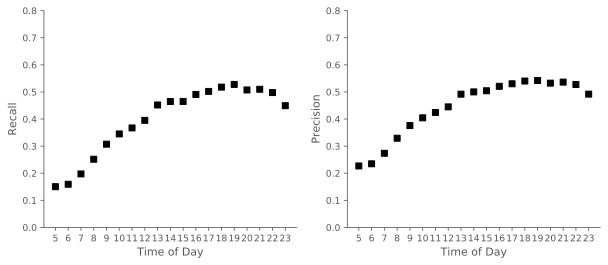

In [32]:
def plot_prec_recall_timeofday(X_, y_, probs):
    """
    Visualize changes in recall and precision over the course of the day
    
    Parameters
    ----------
    X_ : DataFrame
        Features of the data
        
    y_ : DataFrame
        Labels of the data
                
    probs : DataFrame
        Model predicted probabilities (model.predict_proba(X_))
                
    Returns
    -------
    A figure
    """
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    axes[0].set_xlabel('Time of Day')
    axes[0].set_ylabel('Recall')
    axes[0].set_ylim(0,0.8)

    axes[1].set_xlabel('Time of Day')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim(0,0.8)

    hrs = range(5,24)
    for hr in hrs:
        fpr, tpr, prec = [],[],[]
        for thresh in np.arange(0.1,1.0,0.1):
            tp = len(y_[(probs[:,1] > thresh) & (y_==1) & (X_['CRS_DEP_HOUR']==hr)])
            fp = len(y_[(probs[:,1] > thresh) & (y_==0) & (X_['CRS_DEP_HOUR']==hr)])

            tn = len(y_[(probs[:,1] <= thresh) & (y_==0) & (X_['CRS_DEP_HOUR']==hr)])
            fn = len(y_[(probs[:,1] <= thresh) & (y_==1) & (X_['CRS_DEP_HOUR']==hr)])

            if tp+fn>0:
                tpr.append(tp/(tp+fn))
            else:
                tpr.append(np.nan)

            if tp+fp > 0:
                prec.append(tp/(tp+fp))
            else:
                prec.append(np.nan)

            if thresh == 0.5:
                tpr_tot = tp/(tp+fn)
                prec_tot = tp/(tp+fp)

                axes[0].plot([hr], [tpr_tot], 's', color='k')
                axes[1].plot([hr], [prec_tot], 's', color='k')
                
    axes[0].set_xticks(hrs)
    axes[1].set_xticks(hrs)
    return fig

plot_prec_recall_timeofday(X_test, y_test, probas);

The plot above shows the recall and precision for our 2018 model (on 2018 data), in individual time bins. We can see that both recall and precision increase over the course of the day.

So -- if you're going to use this model, the later in the day the better!

---
**<center><font size="6">Alternate optimization choices</font></center>**

One of the choices we made earlier during the hyperparameter-tuning stage was to *not* assign any class weights when calculating information gain at each node in our decision trees. 

It's interesting to look at what would have happened if we had gone another way, though -- for instance assigning `class_weight='balanced'` instead of `None`. 

In the cell below, we'll recreate the plot that explored the effects of changing `min_samples_leaf` and `min_samples_split` -- but this time with balanced class weights. We'll also return to using only data from 2018 for consistency:

Setting parameters: {'clf__min_samples_leaf': 1}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.1s remaining:   51.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.4s remaining:   25.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__min_samples_leaf': 2}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.8s remaining:   47.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.1s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished




Setting parameters: {'clf__min_samples_leaf': 3}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished




Setting parameters: {'clf__min_samples_leaf': 5}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.4s remaining:   49.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished




Setting parameters: {'clf__min_samples_leaf': 9}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   15.9s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   12.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished




Setting parameters: {'clf__min_samples_split': 2}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.0s remaining:   51.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    8.1s remaining:   24.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished




Setting parameters: {'clf__min_samples_split': 4}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.4s remaining:   52.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.3s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.6s remaining:   22.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished




Setting parameters: {'clf__min_samples_split': 6}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   13.1s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.6s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    7.3s remaining:   21.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished




Setting parameters: {'clf__min_samples_split': 10}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.9s remaining:   50.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.7s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.5s remaining:   19.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished




Setting parameters: {'clf__min_samples_split': 20}
  .. training classifier ..


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   16.0s remaining:   48.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished


  .. evaluating classifier ..


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.5s remaining:   16.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished


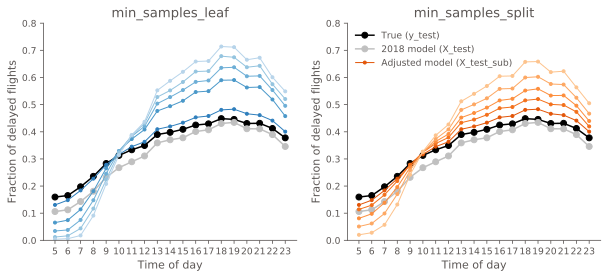

In [33]:
# parameters to change
leaf_params = {'clf__min_samples_leaf':[1,2,3,5,9]} # the default value is 1
train_scores, test_scores, leaf_pipes = multiparam_mansearch(leaf_params, 
                                                            X_train_sub, y_train_sub, 
                                                            X_test_sub, y_test_sub, class_weights='balanced')

split_params = {'clf__min_samples_split':[2,4,6,10,20]} # the default value is 2
train_scores, test_scores, split_pipes = multiparam_mansearch(split_params, 
                                                                X_train_sub, y_train_sub, 
                                                                X_test_sub, y_test_sub, class_weights='balanced')

plot_trends_hyperparams(X_test, y_test, pipe2018, leaf_pipes, split_pipes);

In the plot above, the **<font size="3">black points</font>** and **<span style="color:#939594"><font size="3">grey points</font></span>** are identical to the previous version -- they show the true delayed fractions as a function of time of day and the predictions from our 2018 model, respectively.

However, this time, the **<span style="color:#4370DA"><font size="3">blue curves</font></span>** and **<span style="color:#FF8423"><font size="3">orange curves</font></span>** show the effect of adjusting `min_samples_leaf` and `min_samples_split` for a model with `class_weight='balanced'`.

---

Clearly, this model does not do a great job of capturing the trend of more delayed flights later in the day! This is unfortunate, because it is one of the stronger trends in the data. 

What's going on? Assigning `class_weights='balanced'` will increase the importance of delayed flights (the minority class) -- more specifically, it is effectively oversampling this class (or undersampling the on-time flights) to artificially increase the ratio of delayed to on-time flights. This in turn makes it easier to classify flights as delayed. 

However, we can see that the *slopes* of the model curves are very different from the data. There is a pivot point that occurs when the fraction of delayed flights in a given time been exceeds the global average (~34%). Above this point, it becomes increasingly easy to create nodes where the majority of flights are delayed -- below this, it remains difficult, even with balanced class weights. 

---

Looking at the plot, there's a pretty big jump from `min_samples_leaf=1` to `min_samples_leaf=2`! On the other hand, `min_samples_split` varies a little bit more smoothly. 

Eyeballing from this, it seems that we get closest to the true trends if `min_samples_leaf=1` and `min_samples_leaf=[2,4]`.

---

So, why would we use this over our earlier 2018 model? 

Well -- what if we didn't care about using the model to help us choose what time of day to fly, and instead simply wanted to identify as many delayed flights as possible? We might then prefer this model, because it has a (slightly) higher recall overall, particularly at later times of the day:

Setting parameters: {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__class_weight': 'balanced'}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   26.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   27.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.8s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished


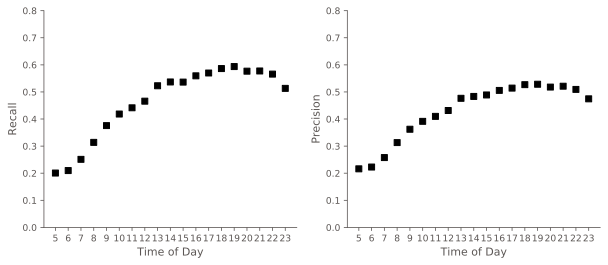

In [34]:
# best hyperparams based on grid searching
param_dict = {'clf__min_samples_leaf':1, 'clf__min_samples_split':2, 'clf__class_weight':'balanced'}
print('Setting parameters: %s' % param_dict)
pipe_weights = init_pipe()
pipe_weights.set_params(**param_dict)

# train on the full training set
pipe_weights.fit(X_train, y_train)

# check recall and precision
probas_weights = pipe_weights.predict_proba(X_test)
plot_prec_recall_timeofday(X_test, y_test, probas_weights);

---
**<center><font size="6">Takeaway #2: Model optimization depends on the question you want to answer</font></center>**

Clearly, our specific project goals come into play when designing a model. In this case, if the thing we care about is reproducing the data and its trends, then we would optimize differently than if we just wanted to find as many delayed flights as possible. 

This is a common theme in building models - there are many tradeoffs to be made, and often the only "right" answer is the one that is more relevant for what you want to accomplish. 

---
**<center><font size="6">Caveats and ideas for future work</font></center>**

There are a number of additional directions we could have taken this project in, given infinite time.

For example, we could have trained our model on a longer baseline (going back further than 2018), or included international flights and/or domestic flights within other countries instead of restricting our analysis to the United States.

We could have built a regression model to try to predict the actual delay time instead of classifying delayed vs on-time. Related, we could have changed our definition of "delayed", for example by increasing it from 0 minutes to 30 minutes or so (something a bit more noticeable). 

... and the list goes on! But for now, on to the next project :) 